# WeatherPy
----

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sit have 0%, 40%, 75%, and 90% cloudiness.  As expected this does change each day the data is pulled.
* There is no strong relationship between closeness to the equater and wind speed. Though 20 degrees latitude does appear to be a wind speed low point, with wind speed growing the further south and north you go from this latitude. This may be related to the eliptical rotation defined by the Tropic of Cancer and Tropic of Capricorn or just current weather conditions. This would be an interesting data point to review over the course of a year or years.



In [10]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
import os

# Import API keys
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Incorporate datetime to grab the date the data was collected
from datetime import datetime

# Output File (CSV)
output_directory = "output_data"
output_data_file = "cities.csv"
output_full_path = output_directory + "/" + output_data_file

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)


## Generate Cities List

In [11]:
# check to see if a previous run of the weather data exists
# initialize filefound to False
filefound = False

# search for the input_file_name. If it is found flip filefound to True
for root, dirs, files in os.walk(output_directory):
    if output_data_file in files:
        filefound = True

# determine if the user wants to refresh the weather data file or use the last run file
# if a input_file_name file does not exist then set rerun to "y" and build a new csv
if filefound == True:
    rerun = input(f"Do you want to refresh the {output_data_file} file(y/n)? ").lower
else:
    rerun = "y"

if rerun == "y": 


    # List for holding lat_lngs and cities
    lat_lngs = []
    cities = []

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
    lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
    lat_lngs = zip(lats, lngs)

    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)

    # Print the city count to confirm sufficient count
    print(len(cities))

    # Define data elements needed for analysis
    cloud = []
    country = []
    date = []
    humidity = []
    lat = []
    lng = []
    max_temp = []
    wind_spd = []
    citywdata = []

    # Save config information.
    url = "http://api.openweathermap.org/data/2.5/weather?"
    units = "imperial"

    # Build partial query URL
    query_url = f"{url}appid={api_key}&units={units}&q="


Do you want to refresh the cities.csv file(y/n)? n


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [12]:
# if the user wishes to build a weather_data.csv file then run the API request loop

if rerun == "y": 
# define and initialize the FOR LOOP counters used to batch the API requests 
    recordcnt = 0
    setcnt = 1

    # FOR LOOP used to gather all the city weather data.  This includes a 10 second sleep every 51 requests
    for city in cities:
        response = requests.get(query_url + city).json()
        if recordcnt > 50:
    # This break statement is used for debugging and allows the script to collect 51 cities so there is a small usable dataset
    # for coding and troubleshooting.
    #         break
            recordcnt = 0
            setcnt += 1
            time.sleep(10)
        if response['cod'] == "404":
            print("City not found. Skipping...")
        elif response['cod'] == 200:
            print(f"Processing Record {recordcnt} of Set {setcnt} | {city}")
            recordcnt += 1
            citywdata.append(city)
            cloud.append(response['clouds']['all'])
            country.append(response['sys']['country'])
            date.append(response['dt'])
            humidity.append(response['main']['humidity'])
            lat.append(response['coord']['lat'])
            lng.append(response['coord']['lon'])
            max_temp.append(response['main']['temp_max'])
            wind_spd.append(response['wind']['speed'])
    print("-----------------------------\nData Retrieval Complete\n-----------------------------")


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [13]:
# if the the csv file is to be rebuilt build a dictionary with all the data elements collected in the FOR LOOP
if rerun == 'y': 

    weather_dict = {
        "city": citywdata,
        "cloud": cloud,
        "country": country,
        "date": date,
        "humidity": humidity,
        "lat": lat,
        "lng": lng,
        "max_temp": max_temp,
        "wind_spd": wind_spd
    }

    # Create a dataframe based on the dictionary
    weather_data = pd.DataFrame(weather_dict)


    # save the file to a CSV for offline processing.  This csv can be used instead of the API call for future develop efforts
    weather_data.to_csv(output_full_path, encoding='utf-8', index=False)

# if the user wants to use the existing csv file build the DF from the existing csv file.
else:
    weather_data = pd.read_csv(output_full_path, encoding="utf-8")

# define the rundate as the date the file was last modified, this is used in the chart titles
rundate = datetime.fromtimestamp(os.stat(output_full_path).st_mtime).strftime('%m-%d-%Y')

# point of interest - two of my cities are missing country codes.  Based on this I opted to add a step to dropnas

weather_data = weather_data.dropna(how='any')

weather_data.count()



city        538
cloud       538
country     538
date        538
humidity    538
lat         538
lng         538
max_temp    538
wind_spd    538
dtype: int64

In [14]:
# display the dataframe
weather_data.head()

,city,cloud,country,date,humidity,lat,lng,max_temp,wind_spd
0,atuona,92,PF,1547483370,100,-9.80,-139.03,81.15,13.47
1,westport,75,IE,1547481600,93,53.80,-9.52,44.60,5.82
2,san cristobal,20,EC,1547481600,49,-0.39,-78.55,68.00,4.70
3,souillac,90,FR,1547481600,66,45.60,-0.60,50.00,10.29
4,hilo,75,US,1547481180,63,19.71,-155.08,68.00,6.93


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

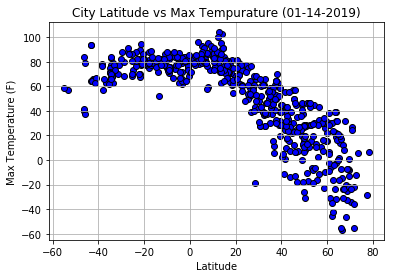

In [15]:
# Create a scatter plot crossing Lat vs Temp
fig, ax = plt.subplots()

plt.scatter(weather_data['lat'], weather_data['max_temp'], marker="o", facecolors="blue", edgecolors="black")
plt.title(f"City Latitude vs Max Tempurature ({rundate})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

ax.grid()


#### Latitude vs. Humidity Plot

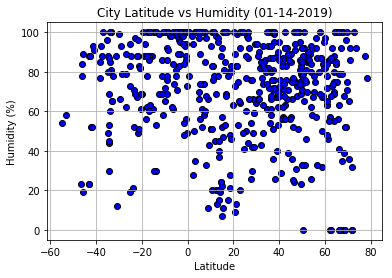

In [16]:
fig, ax = plt.subplots()

plt.scatter(weather_data['lat'], weather_data['humidity'], marker="o", facecolors="blue", edgecolors="black")

plt.title(f"City Latitude vs Humidity ({rundate})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

ax.grid()

#### Latitude vs. Cloudiness Plot

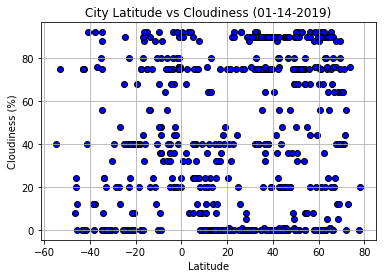

In [17]:
fig, ax = plt.subplots()

plt.scatter(weather_data['lat'], weather_data['cloud'], marker="o", facecolors="blue", edgecolors="black")

plt.title(f"City Latitude vs Cloudiness ({rundate})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

ax.grid()

#### Latitude vs. Wind Speed Plot

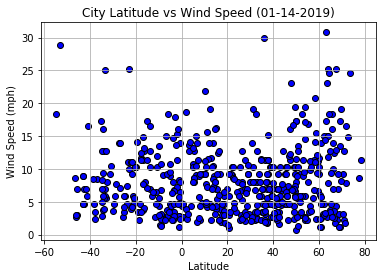

In [18]:
fig, ax = plt.subplots()

plt.scatter(weather_data['lat'], weather_data['wind_spd'], marker="o", facecolors="blue", edgecolors="black")

plt.title(f"City Latitude vs Wind Speed ({rundate})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

ax.grid()